### Import packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cart
import pyresample
import warnings
import ecco_v4_py as ecco
warnings.filterwarnings('ignore')

import warnings
import cmocean
from dask.distributed import Client

from xmitgcm import llcreader

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

### Create the grid

In [2]:
# define basin we want - here 6 is for Barents
# we can look directly at the layers output if we want to:
#  cd /scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/
iB = 6   # see mskBasin if you want for later; maybe we should write this to file

dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"
dirtrsp = dirDiags + "TRSP/"

bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

# write the wet mask and also set to nan
wetmask = mygrid['hFacC']
print(wetmask.shape)
wetmask_tracer = get_aste_tracer(wetmask,nfx,nfy)
print("hey",wetmask_tracer.shape)
wetmask_tracer[:,450:,:270] = np.nan
wetmask = aste_tracer2compact(wetmask_tracer,nfx,nfy)
print(wetmask.shape)

dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsBasin = {'title' : 'CanadaB: 0, ChukchiS: 1, MakarovB: 2, AmundsenB: 3, NansenB: 4, BeringS: 5, BarentsS: 6, GINs: 7, CAA: 8, SPG: 9, LabSea: 10, NPac: 11, NAtlantic: 12, AtlS30: 13',
              'standard_name' : 'Basins labeled',
             'units' : 'degree_c'}

attrsWet= {'title' : 'model wet points in compact form',
         'standard_name' : '1= wet, 0=dry',
         'units' : 'boolean'}

# add mskBasin and wetmask to the xarray for the dataset
mskBasin_3D = xr.DataArray(data = mskBasin*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsBasin)

mskBasin_2D = xr.DataArray(data = mskBasin*wetmask[0,:,:],
                    dims = dims[1:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = attrsBasin)

wetmask_xr = xr.DataArray(data = wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsWet)


ds = xr.Dataset()
ds['mskBasin_3D'] = mskBasin_3D
ds['mskBasin_2D'] = mskBasin_2D
ds['wetmask'] = wetmask_xr

(50,) (50, 1350, 270)
hf1 (1350, 270)
shape of tracer fld: (1, 900, 540)
(1, 1350, 270)
compact shape (1, 1350, 270)
(50, 1350, 270)
hey (50, 900, 540)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
(50, 1350, 270)


In [3]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.arange(12,13,1)
times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)
ffac = 1
# ocean and ice
AB_gT=0
AB_gS=0
debug = False
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
dt

2678400.0

### Functionality to fill with ASTE faces

nx 270
sz [1350  270]
(1, 1350, 270)
tmp (1, 450, 270)


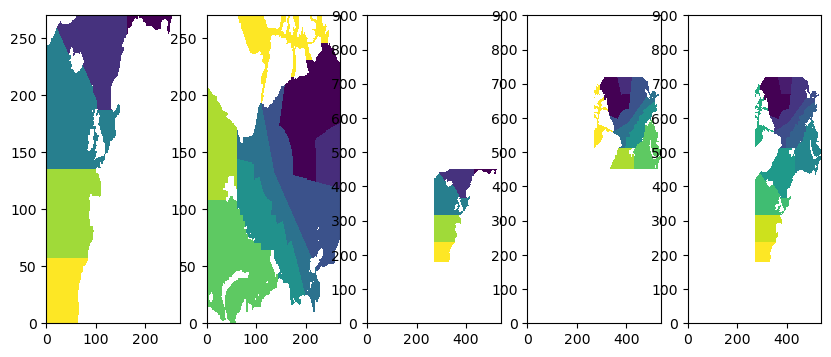

In [4]:
mskfaces = get_aste_faces(mskBasin,nfx,nfy)
test = np.full((ny,nx),np.nan)
test[nfx[3]:nfy[0],0:nx] = mskBasin[nfx[3]:nfy[0],0:nx]

test2 = np.full((ny,nx),np.nan)
test2[nfy[0]:nfy[0]+nfy[2],0:nx]  = mskBasin[nfy[0]:nfy[0]+nfy[2],0:nx]

test3 = test.copy()
test3[nfy[0]:nfy[0]+nfy[2],0:nx]  = mskBasin[nfy[0]:nfy[0]+nfy[2],0:nx]

fig = plt.figure()

ax = plt.subplot(151)
ax.pcolormesh(mskfaces.f1[0][-270:])

ax = plt.subplot(152)
ax.pcolormesh(mskfaces.f3[0])

ax = plt.subplot(153)
ax.pcolormesh(get_aste_tracer(test,nfx,nfy)[0])

ax = plt.subplot(154)
ax.pcolormesh(get_aste_tracer(test2,nfx,nfy)[0])

ax = plt.subplot(155)
ax.pcolormesh(get_aste_tracer(test3,nfx,nfy)[0])

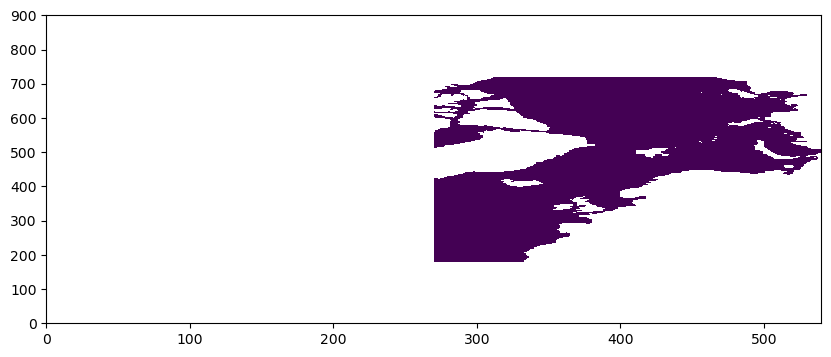

In [5]:
aste_facesmsk = np.full((ny,nx),np.nan)
aste_facesmsk[~np.isnan(test3)] = 1
plt.pcolormesh(get_aste_tracer(aste_facesmsk,nfx,nfy)[0])

### Double check to see the values read in UVELMASS are the same in both files
They are not but that might be because of the vector transformation

In [6]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('RdBu_r',51).copy()
cmap.set_under(color='white')

In [7]:
aste = llcreader.SverdrupASTE270Model()
ds = aste.get_dataset()


In [8]:
ds.coords['rA']

<xarray.DataArray 'rA' (face: 6, j: 270, i: 270)>
dask.array<concatenate, shape=(6, 270, 270), dtype=float64, chunksize=(2, 270, 270), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5
  * i        (i) int64 0 1 2 3 4 5 6 7 8 ... 261 262 263 264 265 266 267 268 269
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 261 262 263 264 265 266 267 268 269
    CS       (face, j, i) float64 dask.array<chunksize=(2, 270, 270), meta=np.ndarray>
    SN       (face, j, i) float64 dask.array<chunksize=(2, 270, 270), meta=np.ndarray>
    Depth    (face, j, i) float64 dask.array<chunksize=(2, 270, 270), meta=np.ndarray>
    rA       (face, j, i) float64 dask.array<chunksize=(2, 270, 270), meta=np.ndarray>
    XC       (face, j, i) float64 dask.array<chunksize=(2, 270, 270), meta=np.ndarray>
    YC       (face, j, i) float64 dask.array<chunksize=(2, 270, 270), meta=np.ndarray>
    maskInC  (face, j, i) float64 dask.array<chunksize=(2, 270, 270), meta=np.ndarray>
Attributes:
    standard_name:  cell_area
    long_name:      cell area
    units:          m2
    coordinate:     YC XC

In [9]:
ds = ds.rename({'face':'tile'})
cds = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)

In [18]:
ds['UVELMASS']

<xarray.DataArray 'UVELMASS' (time: 1, k: 50, tile: 6, j: 270, i_g: 270)>
dask.array<getitem, shape=(1, 50, 6, 270, 270), dtype=float64, chunksize=(1, 1, 2, 270, 270), chunktype=numpy.ndarray>
Coordinates:
  * tile     (tile) int64 0 1 2 3 4 5
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 261 262 263 264 265 266 267 268 269
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 2015-01-01
Attributes:
    standard_name:  UVELMASS
    long_name:      Zonal Mass-Weighted Comp of Velocity (m/s)
    units:          m/s
    mate:           VVELMASS

In [11]:
# add hconv
ds = aste.get_dataset()
ds = ds.sel(time='2015-01')
ds = ds.rename({'face':'tile'})
cds = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)
grid = ecco.get_llc_grid(cds,domain='aste')
uvel,vvel = ecco.vector_calc.UEVNfromUXVY(ds['UVELMASS'],
                                                ds['VVELMASS'],
                                                coords=cds,
                                                grid=grid)

In [17]:
ds['VVELMASS']

<xarray.DataArray 'VVELMASS' (time: 1, k: 50, tile: 6, j_g: 270, i: 270)>
dask.array<getitem, shape=(1, 50, 6, 270, 270), dtype=float64, chunksize=(1, 1, 2, 270, 270), chunktype=numpy.ndarray>
Coordinates:
  * tile     (tile) int64 0 1 2 3 4 5
  * i        (i) int64 0 1 2 3 4 5 6 7 8 ... 261 262 263 264 265 266 267 268 269
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 2015-01-01
Attributes:
    standard_name:  VVELMASS
    long_name:      Meridional Mass-Weighted Comp of Velocity (m/s)
    units:          m/s
    mate:           UVELMASS

In [12]:
cds

<xarray.Dataset>
Dimensions:    (tile: 6, i: 270, i_g: 270, j: 270, j_g: 270, k: 50, k_u: 50,
                k_l: 50, k_p1: 51, time: 1)
Coordinates:
  * tile       (tile) int64 0 1 2 3 4 5
  * i          (i) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j          (j) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time       (time) datetime64[ns] 2015-01-01
Data variables: (12/37)
    niter      (time) int64 ...
    CS         (tile, j, i) float64 dask.array<chunksize=(2, 270, 270), meta=np.ndarray>
    SN         (tile, j, i) float64 dask.array<chunksize=(2, 270, 270), meta=np.ndarray>
    drC        (k_p1) >f8 dask.array<chunksize=(51,), meta=np.ndarray>
    drF        (k) >f8 dask.array<chunksize=(50,), meta=np.ndarray>
    dxC        (tile, j, i_g) float64 dask.array<chunksize=(2, 270, 270), meta=np.ndarray>
    ...         ...
    maskInS    (tile, j_g, i) float64 dask.array<chunksize=(2, 270, 270), meta=np.ndarray>
    maskInW    (tile, j, i_g) float64 dask.array<chunksize=(2, 270, 270), meta=np.ndarray>
    maskS      (k, tile, j_g, i) float64 dask.array<chunksize=(1, 2, 270, 270), meta=np.ndarray>
    maskW      (k, tile, j, i_g) float64 dask.array<chunksize=(1, 2, 270, 270), meta=np.ndarray>
    Zl         (k_l) >f8 dask.array<chunksize=(50,), meta=np.ndarray>
    Zu         (k_u) >f8 dask.array<chunksize=(50,), meta=np.ndarray>

In [13]:
tile1 = uvel.where(uvel.tile == 1, drop=True)
tile2 = uvel.where(uvel.tile == 2, drop=True)

t = 0
klev = 0
tile = 0
tmp1 = tile1.values[t,:,tile,:,:]
tmp2 = np.array([np.rot90(layer, 3) for layer in tile2.values[t,:,tile,:,:]])

concatuvel = np.concatenate((tmp1, tmp2), axis=1)
concatuvel.shape

(50, 540, 270)

In [12]:
# set each in the array
testu = np.full((nz,ny,nx),np.nan)
testu[:,nfx[3]:nfy[0],0:nx] = tile1.values[t,:,tile,:,:]
testu[:,nfy[0]:nfy[0]+nfy[2],0:nx]  = tile2.values[t,:,tile,:,:]

In [13]:
tile1 = vvel.where(vvel.tile == 1, drop=True)
tile2 = vvel.where(vvel.tile == 2, drop=True)

t = 0
klev = 0
tile = 0
tmp1 = tile1.values[t,:,tile,:,:]
tmp2 = np.array([np.rot90(layer, 3) for layer in tile2.values[t,:,tile,:,:]])

concatvvel = np.concatenate((tmp1, tmp2), axis=1)
concatvvel.shape

(50, 540, 270)

In [14]:
# set each in the array
testv = np.full((nz,ny,nx),np.nan)
testv[:,nfx[3]:nfy[0],0:nx] = tile1.values[t,:,tile,:,:]
testv[:,nfy[0]:nfy[0]+nfy[2],0:nx]  = tile2.values[t,:,tile,:,:]

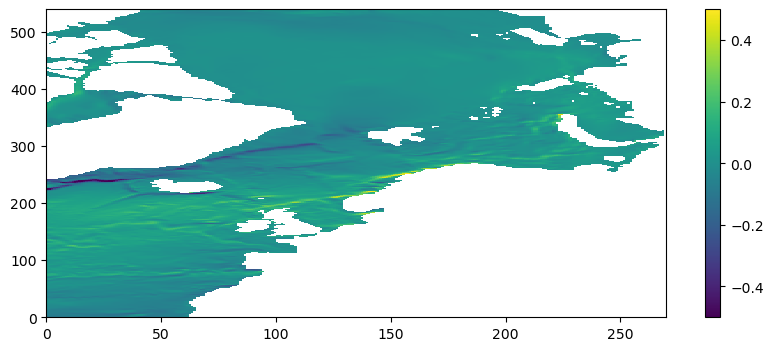

In [15]:
plt.pcolormesh(concatuvel[klev,:,:],vmin=-.5,vmax=.5)
plt.colorbar()

In [16]:
# klev = 0
# fig = plt.figure()

# ax = plt.subplot(131)
# cb = ax.pcolormesh(tile1.values[t,klev,tile,:,:],vmin=-.5,vmax=.5)
# plt.colorbar(cb)

# ax = plt.subplot(132)
# cb = ax.pcolormesh(np.rot90(tile2.values[t,klev,tile,:,:],3),vmin=-.5,vmax=.5)
# plt.colorbar(cb)

# ax = plt.subplot(133)
# cb = ax.pcolormesh(np.vstack((tile1.values[klev,:,:],np.rot90(tile2.values[klev,:,:],3))),cmap = 'seismic',vmin=-1,vmax=1)
# plt.colorbar(cb)
# a = np.vstack((tile1.values[0,:,:],np.rot90(tile2.values[0,:,:],3)))

In [17]:
# grid = ecco.get_llc_grid(cds,domain='aste')
# uvel,vvel = ecco.vector_calc.UEVNfromUXVY(ds['UVELMASS'].sel(k=0),
#                                                 ds['VVELMASS'].sel(k=0),
#                                                 coords=cds,
#                                                 grid=grid)

# tile1 = uvel.where(uvel.tile == 1, drop=True)
# tile2 = uvel.where(uvel.tile == 2, drop=True)


# fig = plt.figure()

# ax = plt.subplot(131)
# cb = ax.pcolormesh(tile1.values[0,0,:,:],vmin=-.5,vmax=.5)
# plt.colorbar(cb)

# ax = plt.subplot(132)
# cb = ax.pcolormesh(np.rot90(tile2.values[0,0,:,:],3),vmin=-.5,vmax=.5)
# plt.colorbar(cb)

# ax = plt.subplot(133)
# cb = ax.pcolormesh(np.vstack((tile1.values[0,0,:,:],np.rot90(tile2.values[0,0,:,:],3))),cmap = 'seismic',vmin=-1,vmax=1)
# plt.colorbar(cb)
# a = np.vstack((tile1.values[0,0,:,:],np.rot90(tile2.values[0,0,:,:],3)))

In [18]:
# try to set the big array to this then plot Bering sea mask
mskcopy = np.full((ny,nx),np.nan)
aste_facesmsk

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [19]:
# plt.pcolormesh(np.rot90(tile2.values[0,0,:,:],3),vmin=-.5,vmax=.5)

In [20]:


# test3 = test.copy()
# test3[nfy[0]:nfy[0]+nfy[2],0:nx]  = mskBasin[nfy[0]:nfy[0]+nfy[2],0:nx]

In [21]:
# get the number of points in the basin and we can use this as a mask for later
mymsk = mskBasin.copy()
mymsk[mymsk != iB] = np.nan
npoints = len(np.where(mymsk == iB)[0])   # set number of points in the basin to be used later
print(npoints)

10650


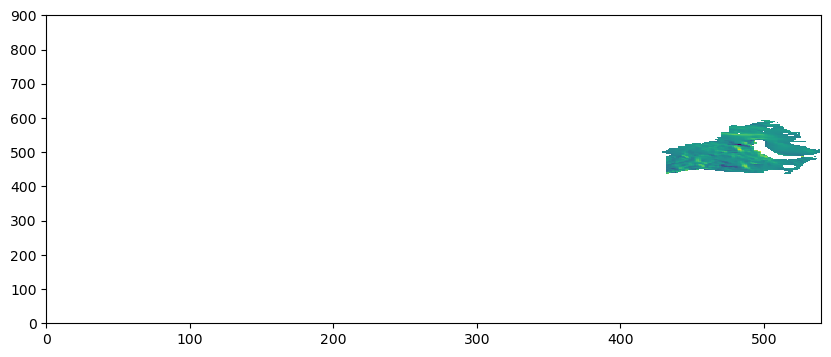

In [22]:
plt.pcolormesh(get_aste_tracer(testv*mymsk/iB,nfx,nfy)[0])

### Great, now let's try to plot u and v and do a convergence in the barents sea

In [23]:
testu.shape

(50, 1350, 270)

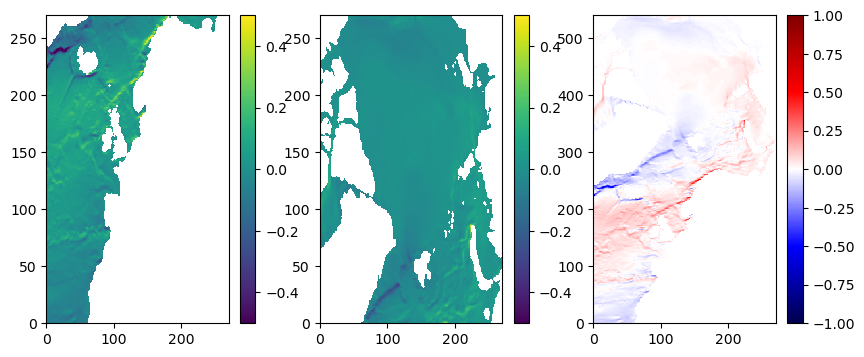

In [24]:
grid = ecco.get_llc_grid(cds,domain='aste')
uvel,vvel = ecco.vector_calc.UEVNfromUXVY(ds['UVELMASS'].sel(k=0),
                                                ds['VVELMASS'].sel(k=0),
                                                coords=cds,
                                                grid=grid)

tile1 = uvel.where(uvel.tile == 1, drop=True)
tile2 = uvel.where(uvel.tile == 2, drop=True)


fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(tile1.values[0,0,:,:],vmin=-.5,vmax=.5)
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(np.rot90(tile2.values[0,0,:,:],3),vmin=-.5,vmax=.5)
plt.colorbar(cb)

ax = plt.subplot(133)
cb = ax.pcolormesh(np.vstack((tile1.values[0,0,:,:],np.rot90(tile2.values[0,0,:,:],3))),cmap = 'seismic',vmin=-1,vmax=1)
plt.colorbar(cb)
a = np.vstack((tile1.values[0,0,:,:],np.rot90(tile2.values[0,0,:,:],3)))

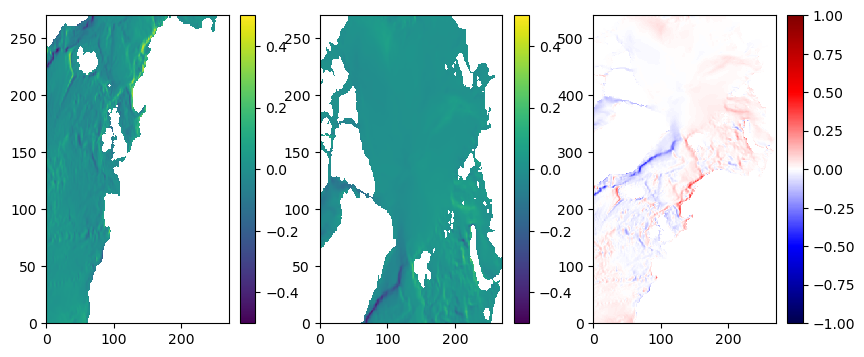

In [25]:
tile1 = vvel.where(uvel.tile == 1, drop=True)
tile2 = vvel.where(uvel.tile == 2, drop=True)


fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(tile1.values[0,0,:,:],vmin=-.5,vmax=.5)
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(np.rot90(tile2.values[0,0,:,:],3),vmin=-.5,vmax=.5)
plt.colorbar(cb)

ax = plt.subplot(133)
cb = ax.pcolormesh(np.vstack((tile1.values[0,0,:,:],np.rot90(tile2.values[0,0,:,:],3))),cmap = 'seismic',vmin=-1,vmax=1)
plt.colorbar(cb)
b = np.vstack((tile1.values[0,0,:,:],np.rot90(tile2.values[0,0,:,:],3)))

In [28]:
mymsk.shape

(1350, 270)

In [34]:
mymsktranslation = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsktranslation = mymsktranslation[180:180+540,270:]

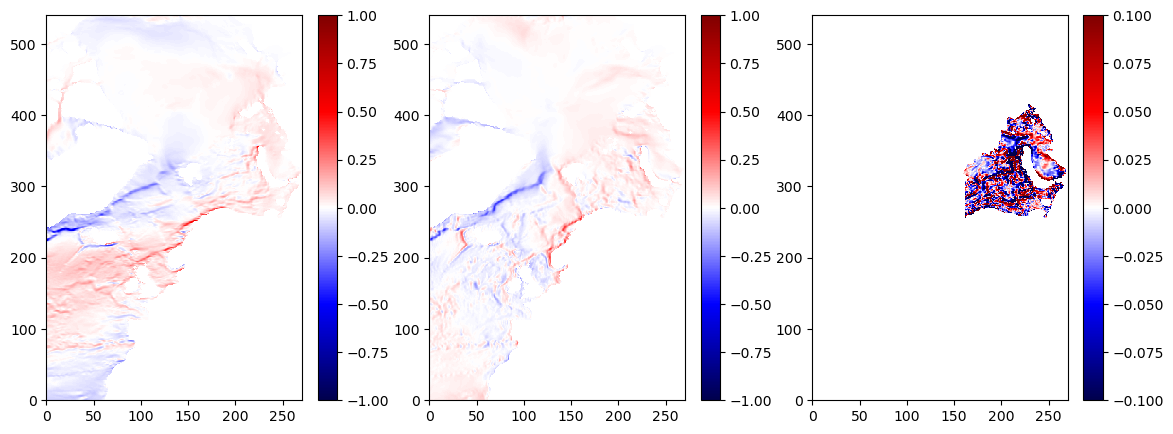

In [35]:
fig = plt.figure(figsize=(14,5))
ax = plt.subplot(131)
cb = ax.pcolormesh(a,cmap = 'seismic',vmin=-1,vmax=1)
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(b,cmap = 'seismic',vmin=-1,vmax=1)
plt.colorbar(cb)

ax = plt.subplot(133)
cb = ax.pcolormesh(calc_UV_conv_1face(a,b)[0]*mymsktranslation,cmap = 'seismic',vmin=-.1,vmax=.1)
plt.colorbar(cb)

In [219]:
c = calc_UV_conv_1face(a,b)
c.shape

(1, 540, 270)

In [220]:
# set each in the array
test = np.full((ny,nx),np.nan)
test[nfx[3]:nfy[0],0:nx] = c[0,:nfy[2]]
test[nfy[0]:nfy[0]+nfy[2],0:nx]  = c[0,nfy[2]:]

In [221]:
nfy

array([450,   0, 270, 270, 270])

(400.0, 600.0)

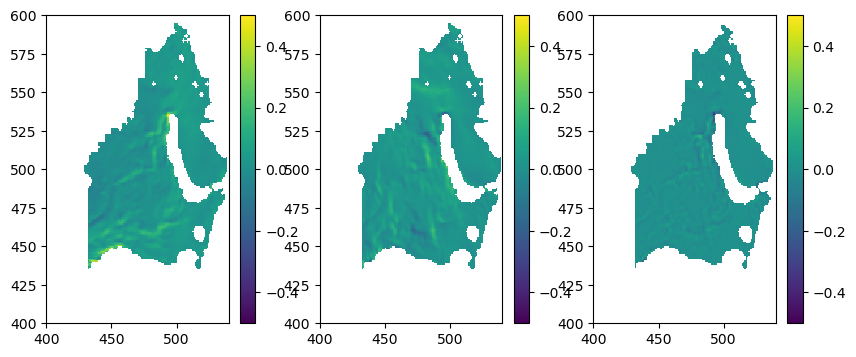

In [222]:
# concat
fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(get_aste_tracer(testu*mymsk/iB,nfx,nfy)[0],vmin=-.5,vmax=.5)
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(132)
cb = ax.pcolormesh(get_aste_tracer(testv*mymsk/iB,nfx,nfy)[0],vmin=-.5,vmax=.5)
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(133)
uvconv = calc_UV_conv_1face(get_aste_tracer(testu*mymsk/iB,nfx,nfy)[0],get_aste_tracer(testv*mymsk/iB,nfx,nfy)[0])
cb = ax.pcolormesh(uvconv[0],vmin=-.5,vmax=.5)
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)

(400.0, 600.0)

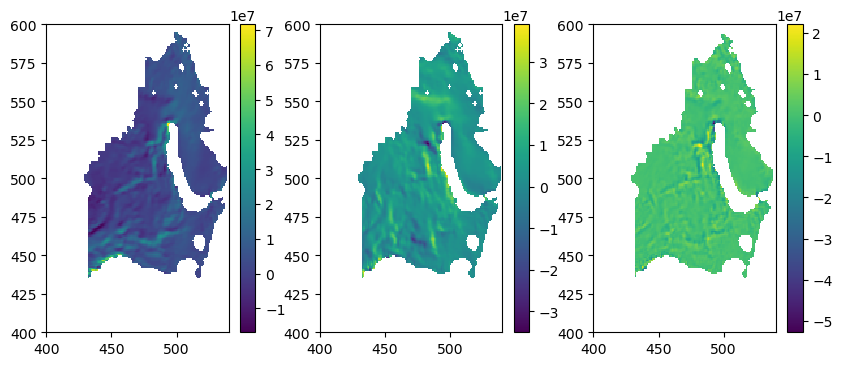

In [223]:
tmpUo = myparms['rhoconst'] * dyg3d * drf3d * testu*mymsk/iB
tmpVo = myparms['rhoconst'] * dyg3d * drf3d * testv*mymsk/iB

# concat
fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(get_aste_tracer(tmpUo,nfx,nfy)[0])
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(132)
cb = ax.pcolormesh(get_aste_tracer(tmpVo,nfx,nfy)[0])
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(133)
uvconv = calc_UV_conv_1face(get_aste_tracer(tmpUo,nfx,nfy),get_aste_tracer(tmpVo,nfx,nfy))
cb = ax.pcolormesh(uvconv[0])
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)

In [224]:
oceFWflx1 = ds.oceFWflx.where(ds.oceFWflx.tile ==1,drop=True)
oceFWflx2 = ds.oceFWflx.where(ds.oceFWflx.tile ==2,drop=True)

oceFWflx = np.full((ny,nx),np.nan)
oceFWflx[nfx[3]:nfy[0],0:nx] = oceFWflx1.values[t,tile,:,:]
oceFWflx[nfy[0]:nfy[0]+nfy[2],0:nx]  = oceFWflx2.values[t,tile,:,:]

In [225]:
WVELMASS1 = ds.WVELMASS.where(ds.oceFWflx.tile ==1,drop=True)
WVELMASS2 = ds.WVELMASS.where(ds.oceFWflx.tile ==2,drop=True)

WVELMASS = np.full((nz,ny,nx),np.nan)
WVELMASS[:,nfx[3]:nfy[0],0:nx] = WVELMASS1.values[t,:,tile,:,:]
WVELMASS[:,nfy[0]:nfy[0]+nfy[2],0:nx]  = WVELMASS2.values[t,:,tile,:,:]

In [226]:
# do z convergence
budgO_zconv = oceFWflx

if not myparms["useRFWF"]:
    budgO_zconv = 0 * budgO_zconv

trWtop = -WVELMASS * myparms["rhoconst"]
print(trWtop.shape)

# indexing seems fishy here - rewrite
if myparms["useNLFS"] < 2 or myparms["rStar"] == 0:
    trWtop[0, :, :] = oceFWflx
    if not myparms["useRFWF"]:
        trWtop[0,:, :] = -WVELMASS[0,:, :] * myparms["rhoconst"]

# same size trWtop and TrWbot
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:, :] = trWtop[1:,:, :]

#budgO["fluxes"] = {}
budgO_fluxes_trWtop = trWtop * RAC3
budgO_fluxes_trWbot = trWbot * RAC3
budgO_fluxes_zconv = budgO_fluxes_trWtop - budgO_fluxes_trWbot

# changed axis here to 0 because we're looking at z
if myparms["useNLFS"] < 2 or (myparms["rStar"] == 0 and not myparms["useRFWF"]):
    budgO_zconv += np.sum(trWtop - trWbot, axis=0)

budgO_zconv = RAC * budgO_zconv

(50, 1350, 270)


(400.0, 600.0)

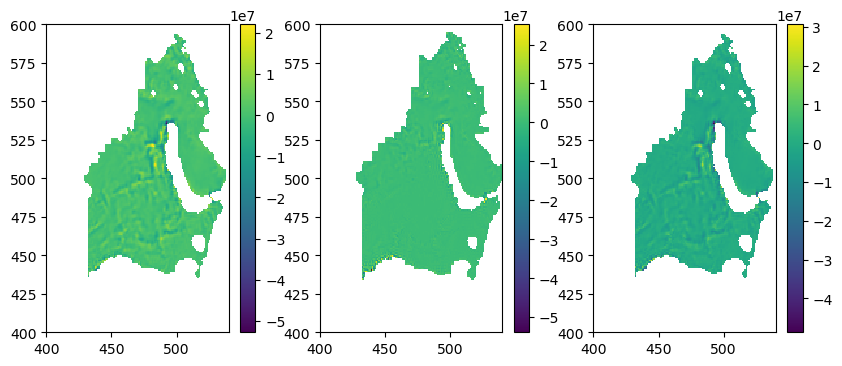

In [227]:
# concat
fig = plt.figure()

# hconv
ax = plt.subplot(131)
uvconv = calc_UV_conv_1face(get_aste_tracer(tmpUo,nfx,nfy),get_aste_tracer(tmpVo,nfx,nfy))
cb = ax.pcolormesh(uvconv[0])
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)

# zconv
ax = plt.subplot(132)
zconv = get_aste_tracer(budgO_fluxes_zconv*mymsk/iB,nfx,nfy)
cb = ax.pcolormesh(get_aste_tracer(budgO_fluxes_zconv*mymsk/iB,nfx,nfy)[0])
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)

# difference
ax = plt.subplot(133)
cb = ax.pcolormesh((uvconv-zconv)[0])
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)


In [228]:
# t1
ETAN1 = ds.ETAN.where(ds.oceFWflx.tile ==1,drop=True)
ETAN2 = ds.ETAN.where(ds.oceFWflx.tile ==2,drop=True)

ETAN = np.full((ny,nx),np.nan)
ETAN[nfx[3]:nfy[0],0:nx] = ETAN1.values[t,tile,:,:]
ETAN[nfy[0]:nfy[0]+nfy[2],0:nx]  = ETAN2.values[t,tile,:,:]

In [229]:
aste = llcreader.CRIOSPortalASTE270Model()
ds = aste.get_dataset()
ds = ds.sel(time=slice('2014-12'))

ds = ds.rename({'face':'tile'})
cds = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)

In [230]:
# t2
ETAN1t2 = ds.ETAN.where(ds.oceFWflx.tile ==1,drop=True)
ETAN2t2 = ds.ETAN.where(ds.oceFWflx.tile ==2,drop=True)

ETANt2 = np.full((ny,nx),np.nan)
ETANt2[nfx[3]:nfy[0],0:nx] = ETAN1t2.values[t,tile,:,:]
ETANt2[nfy[0]:nfy[0]+nfy[2],0:nx]  = ETAN2t2.values[t,tile,:,:]

In [231]:
dETANdt = (ETANt2 - ETAN)/dt

In [236]:
tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC
tmp2 = tmp1/mk3D_mod(DD,tmp1)
tmptend = tmp2 * mk3D_mod(dETANdt, tmp2) * myparms['rhoconst'] * mk3D_mod(RAC, hfC)

(400.0, 600.0)

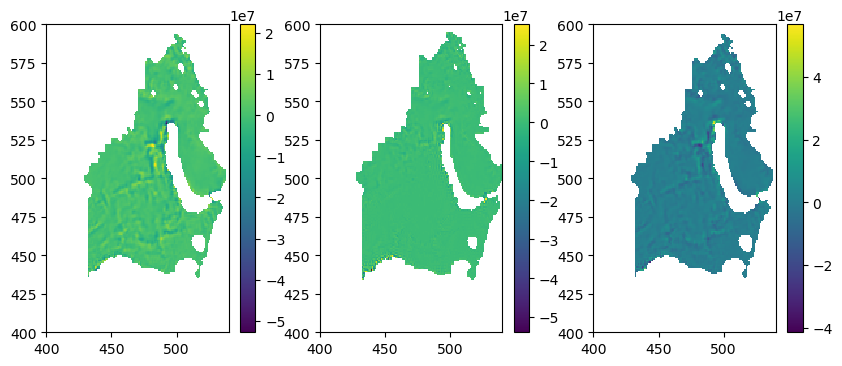

In [241]:
# concat
fig = plt.figure()

# hconv
ax = plt.subplot(131)
uvconv = calc_UV_conv_1face(get_aste_tracer(tmpUo,nfx,nfy),get_aste_tracer(tmpVo,nfx,nfy))
cb = ax.pcolormesh(uvconv[0])
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)

# zconv
ax = plt.subplot(132)
zconv = get_aste_tracer(budgO_fluxes_zconv*mymsk/iB,nfx,nfy)
cb = ax.pcolormesh(get_aste_tracer(budgO_fluxes_zconv*mymsk/iB,nfx,nfy)[0])
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)

# difference
ax = plt.subplot(133)
c = get_aste_tracer(tmptend,nfx,nfy)
cb = ax.pcolormesh((get_aste_tracer(tmptend,nfx,nfy)-uvconv-zconv)[0])
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)

In [240]:
# check for internal convergence

pt = np.array([[475,525,4],
               [550,500,10]])

In [242]:
tmptend2 = c.copy()
budgO_fluxes_zconv = zconv.copy()
budgO_fluxes_hconv = uvconv.copy()
print(tmptend2.shape,budgO_fluxes_zconv.shape,budgO_fluxes_hconv.shape)

(50, 900, 540) (50, 900, 540) (50, 900, 540)


IndexError: index 550 is out of bounds for axis 2 with size 540

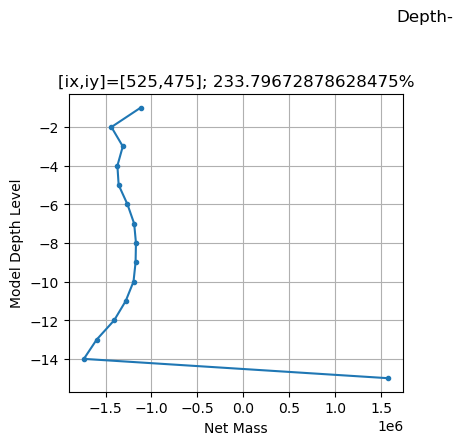

In [243]:
# Figure 1
plt.figure(1, figsize=(9.5, 8.5))
aa = np.zeros((nz, 4))
plt.suptitle("Depth-")

# four figures labeled n
for n in range(1, 3):
    ix, iy, k = pt[n-1]
    aa[:, n-1] = tmptend2[:, iy, ix] - budgO_fluxes_zconv[:, iy, ix] - budgO_fluxes_hconv[:, iy, ix]
    #aa[:, n-1] = budgO['tend'][iy, ix] - budgO['hconv'][0,iy, ix] - budgO['zconv'][iy, ix]

    plt.subplot(2, 2, n)
    plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
    plt.grid()
    #plt.xlabel(f"net budg{strbudg[0]}o")
    plt.xlabel("Net Mass")
    plt.ylabel("Model Depth Level")
    plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO_fluxes_zconv[:,iy, ix]))}%")
        
plt.tight_layout()
plt.show()